## NLP: classify disaster tweets

NLP - or *Natural Language Processing* - is shorthand for a wide array of techniques designed to help machines learn from text. Natural Language Processing powers everything from chatbots to search engines, and is used in diverse tasks like sentiment analysis and machine translation.

In this tutorial we'll look at this competition's dataset, use a simple technique to process it, build a machine learning model, and submit predictions for a score!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing,metrics
from sklearn.linear_model import LogisticRegressionCV
#from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
import re
import string


In [4]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submission_file=pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

#train_df = pd.read_csv("train.csv")
#test_df = pd.read_csv("test.csv")
#submission_file='sample_submission.csv'

In [5]:
print('Training Set Shape = {}'.format(train_df.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train_df.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test_df.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test_df.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


## Visualize target on training set

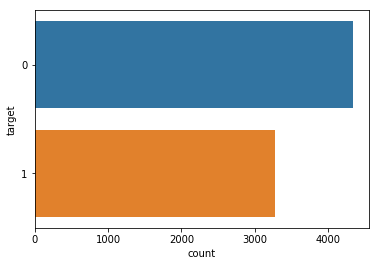

In [6]:
sns.countplot(y=train_df.target);


### Check and manage Missing Values

In [7]:
print('% of missing values for train dataset\n',train_df.isnull().sum()*100/len(train_df))
print('\n')
print('% of missing values for test dataset\n',test_df.isnull().sum()*100/len(train_df))

% of missing values for train dataset
 id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64


% of missing values for test dataset
 id           0.000000
keyword      0.341521
location    14.514646
text         0.000000
dtype: float64


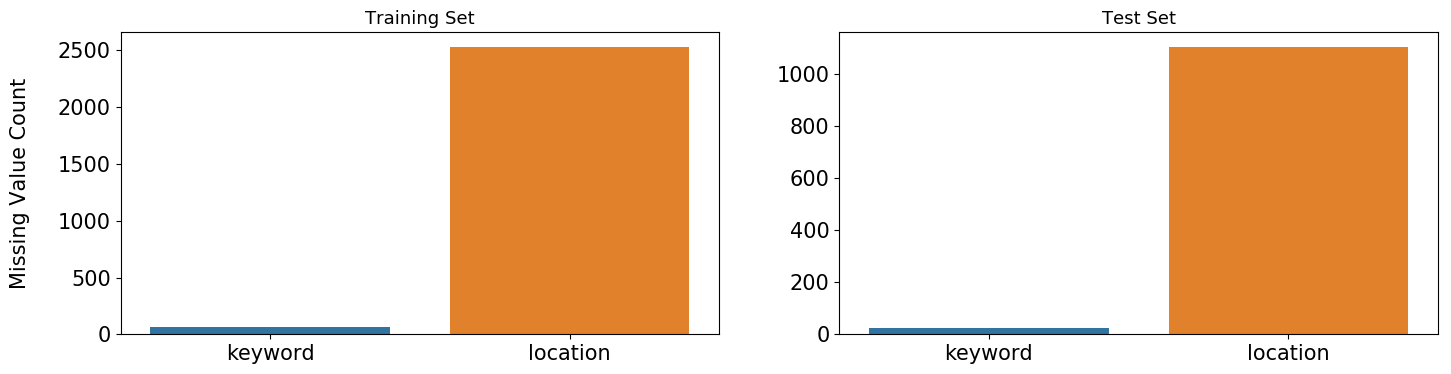

In [8]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=train_df[missing_cols].isnull().sum().index, y=train_df[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=test_df[missing_cols].isnull().sum().index, y=test_df[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()


In [9]:
for df in [train_df, test_df]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

print('% of missing values for train dataset\n',train_df.isnull().sum()*100/len(train_df))
print('\n')
print('% of missing values for test dataset\n',test_df.isnull().sum()*100/len(train_df))


% of missing values for train dataset
 id          0.0
keyword     0.0
location    0.0
text        0.0
target      0.0
dtype: float64


% of missing values for test dataset
 id          0.0
keyword     0.0
location    0.0
text        0.0
dtype: float64


In [ ]:
kw_dis=train_df[train_df['target']==1].keyword.value_counts().head(10)
kw_no_dis=train_df[train_df['target']==0].keyword.value_counts().head(10)
plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(kw_dis, kw_dis.index, color='c')
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_no_dis, kw_no_dis.index, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()

### A quick look at our data

Let's look at our data... first, an example of what is NOT a disaster tweet.

In [ ]:
word_count_disasters=[]
word_count_no_disasters=[]
for elem in train_df[train_df['target']==1]["text"]:
    word_count_disasters.append(len(elem.split()))
for elem in train_df[train_df['target']==0]["text"]:
    word_count_no_disasters.append(len(elem.split()))
    

In [ ]:
print(sum(word_count_disasters)/len(word_count_disasters))
print(sum(word_count_no_disasters)/len(word_count_no_disasters))

And one that is:

### Cleaning text

In [ ]:
punctuation = string.punctuation
print(type(punctuation),punctuation)

In [ ]:
train_df['cleaned_text'] = train_df['text'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)
train_df['cleaned_text'] = train_df['cleaned_text'].replace("  ", " ")

In [ ]:
test_df['cleaned_text'] = test_df['text'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)
test_df['cleaned_text'] = test_df['cleaned_text'].replace("  ", " ")

In [ ]:
def cleantext(df, words_to_remove): 
    ### dont change the original tweet
    # remove emoticons form the tweets
    df['cleaned_text'] = df['cleaned_text'].replace(r'<ed>','', regex = True)
    df['cleaned_text'] = df['cleaned_text'].replace(r'\B<U+.*>|<U+.*>\B|<U+.*>','', regex = True)
    
    # convert tweets to lowercase
    df['cleaned_text'] = df['cleaned_text'].str.lower()
    
    #remove user mentions
    df['cleaned_text'] = df['cleaned_text'].replace(r'^(@\w+)',"", regex=True)
    
    #remove 'rt' in the beginning
    df['cleaned_text'] = df['cleaned_text'].replace(r'^(rt @)',"", regex=True)
    
    #remove_symbols
    df['cleaned_text'] = df['cleaned_text'].replace(r'[^a-zA-Z0-9]', " ", regex=True)

    #remove punctuations 
    df['cleaned_text'] = df['cleaned_text'].replace(r'[[]!"#$%\'()\*+,-./:;<=>?^_`{|}] +',"", regex = True)

    #remove_URL(x):
    df['cleaned_text'] = df['cleaned_text'].replace(r'https.*$', "", regex = True)

    #remove 'amp' in the text
    df['cleaned_text'] = df['cleaned_text'].replace(r'amp',"", regex = True)
    
    #remove words of length 1 or 2 
    df['cleaned_text'] = df['cleaned_text'].replace(r'\b[a-zA-Z]{1,2}\b','', regex=True)

    #remove extra spaces in the tweet
    df['cleaned_text'] = df['cleaned_text'].replace(r'^\s+|\s+$'," ", regex=True)
    return df
    #remove stopwords and words_to_remove
#     stop_words = set(stopwords.words('english'))
#     mystopwords = [stop_words, "via", words_to_remove]
    
#     df['fully_cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in mystopwords]))
    


In [ ]:
train_df_cleaned=cleantext(train_df,'null')
test_df_cleaned=cleantext(test_df,'null')

In [ ]:
from nltk.corpus import stopwords

stopwords_eng=stopwords.words('english')

def remove_stopwords(in_str):
    new_str=''
    words=in_str.split() #string is splitted through white space in a list of words
    for tx in words:
        if tx not in stopwords_eng:
            new_str=new_str + tx + " "
    return new_str

train_df['cleaned_text'] = train_df['cleaned_text'].apply(lambda x: remove_stopwords(x))
test_df['cleaned_text'] = test_df['cleaned_text'].apply(lambda x: remove_stopwords(x))

In [ ]:
train_df

In [ ]:
df1=train_df.drop(columns=['id','keyword','location','text']).copy()

In [ ]:
df2=test_df.drop(columns=['id','keyword','location','text']).copy()

In [ ]:
final_df=df1 = pd.concat([df1, df2], axis = 0,sort=True)


In [ ]:
final_df.isnull().sum()

### Building vectors

The theory behind the model we'll build in this notebook is pretty simple: the words contained in each tweet are a good indicator of whether they're about a real disaster or not (this is not entirely correct, but it's a great place to start).

We'll use scikit-learn's `CountVectorizer` to count the words in each tweet and turn them into data our machine learning model can process.

Note: a `vector` is, in this context, a set of numbers that a machine learning model can work with. We'll look at one in just a second.

In [ ]:
#count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
#example_train_vectors = count_vectorizer.fit_transform(train_df_cleaned["cleaned_text"][0:5])

### Visualizing sparse matrix


In [ ]:
#import matplotlib.pylab as plt
#import scipy.sparse as sparse
#plt.spy(example_train_vectors,markersize=1)
#A = sparse.eye(10)
# visualize the sparse matrix with Spy
#plt.spy(A)

In [ ]:
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
#print(example_train_vectors[0])
#print(example_train_vectors[0].todense().shape)
#print(example_train_vectors[0].todense())

The above tells us that:
1. There are 54 unique words (or "tokens") in the first five tweets.
2. The first tweet contains only some of those unique tokens - all of the non-zero counts above are the tokens that DO exist in the first tweet.

Now let's create vectors for all of our tweets.

In [ ]:
train_vectors = count_vectorizer.fit_transform(final_df["cleaned_text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
#test_vectors = count_vectorizer.transform(test_df["cleaned_text"])

### Our model

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

What we're assuming here is a _linear_ connection. So let's build a linear model and see!

In [ ]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()

Let's test our model and see how well it does on the training data. For this we'll use `cross-validation` - where we train on a portion of the known data, then validate it with the rest. If we do this several times (with different portions) we can get a good idea for how a particular model or method performs.

The metric for this competition is F1, so let's use that here.

In [ ]:
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=5, scoring="f1")
scores.mean()

The above scores aren't terrible! It looks like our assumption will score roughly 0.65 on the leaderboard. There are lots of ways to potentially improve on this (TFIDF, LSA, LSTM / RNNs, the list is long!) - give any of them a shot!

In the meantime, let's do predictions on our training set and build a submission for the competition.

### TF-IDF Vectorizer


In [ ]:
tf_idf_vectorizer = feature_extraction.text.TfidfVectorizer()

train_vectors = tf_idf_vectorizer.fit_transform(final_df["cleaned_text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = tf_idf_vectorizer.transform(test_df["cleaned_text"])

In [ ]:
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=5, scoring="f1")
scores.mean()

In [ ]:
from sklearn import svm
svm_cl=svm.SVC(gamma='auto')
scores = model_selection.cross_val_score(svm_cl, train_vectors, train_df["target"], cv=5)
scores.mean()


In [ ]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [ ]:
svm_cl.fit(train_vectors, train_df["target"])
sample_submission["target"] = svm_cl.predict(test_vectors)

In [ ]:
sample_submission.head()

In [ ]:
sample_submission.to_csv("submission.csv", index=False)

Now, in the viewer, you can submit the above file to the competition! Good luck!